# Determinstic Chain Example
Today: April 23, 2021

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Set up 
### Environment MRP

In [2]:
class LinearChainMRP:
    def __init__(self, n_states=8):
        self.n_states = n_states
        self.state = 0
    
    def step(self):
        reward = 0.0
        done = False
        
        if self.state == (self.n_states-1):
            done = True
            reward = 1.0
        else:
            self.state += 1
                    
        return self.state, reward, done
    
    def reset(self):
        self.state = 0
        return self.state

### Learners

In [3]:
def np_one_hot(dim, idx):
    """Create a one-hot vector"""
    vec = np.zeros(dim)
    vec[idx] = 1.0
    return vec

class ValueFunctionBase:
    def __init__(self, n_states=8, gamma=0.99, lr=0.1):
        self.n_states = n_states
        self.prev_state = None
        self.gamma = gamma
        self.lr = lr
    
    def begin_episode(self, state):
        self.prev_state = state
    
    def step(self, state, reward, done):
        pass
        
    
class MFValue(ValueFunctionBase):
    def __init__(self, n_states=8, gamma=0.99, lr=0.1):
        super().__init__(n_states, gamma, lr)
        self.theta = np.zeros(n_states)
    
    def step(self, state, reward, done):
        # Target and update
        prev_target = reward + ((1 - done) * 
                                self.gamma * self.theta[state])
        theta_delta = prev_target - self.theta[self.prev_state]
        self.theta[self.prev_state] += self.lr * theta_delta
        
        # Continue
        self.prev_state = state

class SFValue(ValueFunctionBase):
    def __init__(self, n_states=8, gamma=0.99, lr=0.1):
        super().__init__(n_states, gamma, lr)
        self.psi = np.identity(n_states)
        self.w = np.zeros(n_states)
        self.theta = np.zeros(n_states)  # dummy variable to be combined
    
    def step(self, state, reward, done):
        # SR lesarning
        prev_phi = np_one_hot(self.n_states, self.prev_state)        
        target = prev_phi + ((1 - done) * 
                             self.gamma * self.psi[state])
        sf_delta = target - self.psi[self.prev_state]
        self.psi[self.prev_state] += self.lr * sf_delta
        
        # Reward learning
        r_delta = reward - self.w[self.prev_state]
        self.w[self.prev_state] += self.lr * r_delta
        
        self.theta = self.psi @ self.w
        
        # Continue
        self.prev_state = state
        
class LambdaValue(ValueFunctionBase):
    def __init__(self, n_states=8, gamma=0.99, lr=0.1, lamb=0.0):
        super().__init__(n_states, gamma, lr)
        self.lamb = lamb
        self.theta = np.zeros(n_states)
        self.psi = np.identity(n_states)
        self.w = np.zeros(n_states)
    
    def step(self, state, reward, done):
        # SR lesarning
        prev_phi = np_one_hot(self.n_states, self.prev_state)        
        target = prev_phi + ((1 - done) * 
                             self.gamma * self.lamb * self.psi[state])
        sf_delta = target - self.psi[self.prev_state]
        self.psi[self.prev_state] += self.lr * sf_delta
        
        # Reward learning
        r_delta = reward - self.w[self.prev_state]
        self.w[self.prev_state] += self.lr * r_delta
        
        # Value learning
        v_vec = self.psi @ (
            ((1-self.lamb) * self.theta) + (self.lamb * self.w)
        )
        v_target = reward + ((1-done) * self.gamma * v_vec[state])
        v_delta = v_target - self.theta[self.prev_state]
        self.theta[self.prev_state] += self.lr * v_delta
        
        # Continue
        self.prev_state = state
    

### Trainer

In [4]:
def train_value(env, learner, num_episodes=3):
    """
    Method to run a learner in an environment
    """
    out_dict = {
        'theta': [],
        'psi': [],
        'w': [],
    }
    
    for episode_idx in range(num_episodes):
        s = env.reset()
        learner.begin_episode(s)
        
        done = False
        while not done:
            s, reward, done = env.step()
            learner.step(s, reward, done)
        
        # store
        if hasattr(learner, 'theta'):
            out_dict['theta'].append(np.copy(learner.theta))
        if hasattr(learner, 'psi'):
            out_dict['psi'].append(np.copy(learner.psi))
        if hasattr(learner, 'w'):
            out_dict['w'].append(np.copy(learner.w))
    
    return out_dict

## Experiment

#### Run experiment

In [5]:
Num_states = 16
Num_episodes = 20
Gamma = 0.9999
Lr = 1.0
    
def run_experiment():
    
    sf_lambda = 0.5
    
    # Agent learners
    learner_dict = {
        'mf': MFValue(n_states=Num_states, gamma=Gamma, lr=Lr),
        'sf': SFValue(n_states=Num_states, gamma=Gamma, lr=Lr),
        'lvf_2': LambdaValue(n_states=Num_states, gamma=Gamma, lr=Lr, lamb=0.2),
        'lvf_5': LambdaValue(n_states=Num_states, gamma=Gamma, lr=Lr, lamb=0.5),
        'lvf_7': LambdaValue(n_states=Num_states, gamma=Gamma, lr=Lr, lamb=0.7),
        'lvf_9': LambdaValue(n_states=Num_states, gamma=Gamma, lr=Lr, lamb=0.9),
    }
    
    # Environment
    env = LinearChainMRP(n_states=Num_states)
    
    # Train
    data_dict = {}
    for k in learner_dict:
        cur_learner = learner_dict[k]
        cur_out = train_value(env, cur_learner, 
                              num_episodes=Num_episodes)
        
        data_dict[k] = cur_out
        print(k, data_dict[k].keys())
    
    return data_dict
        
exp_dict = run_experiment()

mf dict_keys(['theta', 'psi', 'w'])
sf dict_keys(['theta', 'psi', 'w'])
lvf_2 dict_keys(['theta', 'psi', 'w'])
lvf_5 dict_keys(['theta', 'psi', 'w'])
lvf_7 dict_keys(['theta', 'psi', 'w'])
lvf_9 dict_keys(['theta', 'psi', 'w'])


### Visualize

mf
lvf_7
sf


<Figure size 720x201.6 with 0 Axes>

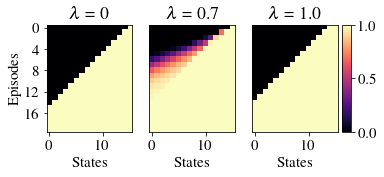

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def script_plt_all_thetas(in_dict):
    only_include = ['mf', 'lvf_7', 'sf']
    
    title_list = ['$\lambda$ = 0', '$\lambda$ = 0.7', '$\lambda$ = 1.0']
    
    plt.figure(figsize=((10, 2.8)))
    subplt_counter = 1
    
    fig, axes = plt.subplots(nrows=1, ncols=len(only_include))
    for idx, ax in enumerate(axes.flat):
        cur_ax_key = only_include[idx]
        
        im = ax.imshow(in_dict[cur_ax_key]['theta'], 
                       cmap='magma',
                       vmin=0.0, vmax=1.0)
        
        print(cur_ax_key)
        ax.title.set_text(title_list[idx])
        if subplt_counter == 1:
            ax.set_ylabel('Episodes')
            cur_yticks = np.arange(Num_episodes, step=4)
            ax.set_yticks(cur_yticks)
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
            
        ax.set_xlabel('States')
        
        subplt_counter += 1
    
    fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar_ax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

    fig.colorbar(im, cax=cbar_ax) 
    
    return fig
    

plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 'serif': ['Times'], 'size': 15})

cur_prop_fig = script_plt_all_thetas(exp_dict)

cur_prop_fig.savefig('/Users/anthony/Desktop/det-chain_value-prop.pdf', bbox_inches="tight")

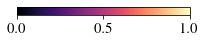

In [12]:
def script_plt_colorbar():
    a = np.array([[0,1]])
    plt.figure(figsize=(3, 0.2))  # (0.2, 3)
    img = plt.imshow(a, cmap="magma")  # cividis
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    plt.colorbar(orientation="horizontal", # vertical, horizontal
                 cax=cax)

script_plt_colorbar()

In [13]:
sns.color_palette("colorblind", 10)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

mf 0.0
lvf_7 0.7
sf 1.0


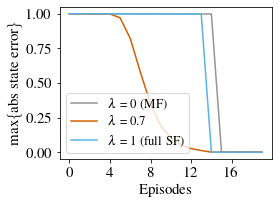

In [22]:
def script_plt_all_errors(in_dict):    
    ag_k_list = ['mf', 'lvf_7', 'sf']  # learner keys 
    ag_k_float_lambda = [0.0, 0.7, 1.0]  # NOTE: correspond to above
    
    # Make true value vector
    true_v = np.zeros(Num_states)
    true_v[-1] = 1.0
    for i in reversed(range((Num_states-1))):
        true_v[i] = Gamma * true_v[i+1]
        
    # Colors
    c10pal = sns.color_palette("colorblind", 10)
    cmapping_keylist = [0.0, 0.3, 0.5, 0.7, 0.9, 0.99, 1.0]
    cmapping_colidxs = [7, 1, 2, 3, 4, 6, 9]
    cmapping = {cmapping_keylist[i]: cmapping_colidxs[i] 
                for i in range(len(cmapping_keylist))}
    
    # Plot error
    plt.figure(figsize=(3.8,2.8))
    lege_list = []
    for i, ag_k in enumerate(ag_k_list):
        delta_vec = in_dict[ag_k]['theta'] - true_v
        err = np.linalg.norm(delta_vec, ord=np.inf, 
                             axis=1)
        
        # Current lambda and color
        cur_lamb = ag_k_float_lambda[i]
        cur_col = c10pal[cmapping[cur_lamb]]
        # 
        plt.plot(err, color=cur_col)
        print(ag_k, cur_lamb)
        
        lege_list.append(ag_k)
        
    # plt.title('Inf Norm Error')
    lege_list = ['$\lambda$ = 0 (MF)', '$\lambda$ = 0.7', '$\lambda$ = 1 (full SF)']
    plt.legend(lege_list, loc='lower left', fontsize=13)
    
    plt.ylabel('max\{abs state error\}')
    plt.xlabel('Episodes')
    cur_xticks = np.arange(Num_episodes, step=4)
    plt.xticks(cur_xticks, cur_xticks)
    

plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 'serif': ['Times'], 'size': 15})


script_plt_all_errors(exp_dict)
plt.savefig('/Users/anthony/Desktop/det-chain_errors.pgf', bbox_inches="tight")

In [80]:
def script_get_vectors(in_dict, epis_idx):
    
    param_k_list = ['theta', 'w', 'psi']  # parameters to see
    ag_k_list = ['mf', 'sf', 'lvf_7']  # learner keys 
    
    for ag_k in in_dict:
        # Check
        if ag_k not in ag_k_list:
            continue
        for param_k in param_k_list:
            # Check
            if not param_k in in_dict[ag_k]:
                continue
            if len(in_dict[ag_k][param_k]) == 0:
                continue
            
            # Get the parameters
            cur_param = in_dict[ag_k][param_k]
            cur_epis_param = cur_param[epis_idx]
            
            if len(np.shape(cur_epis_param)) == 1:
                cur_epis_param = np.expand_dims(
                    cur_epis_param, 0)
            elif len(np.shape(cur_epis_param)) == 2:
                cur_epis_param = cur_epis_param[0:1, :]
            else:
                raise Exception('This is unexpected')
            
            info_str = f'Agent: {ag_k}, Param: {param_k}'
            if param_k == 'theta':
                info_str += f', {cur_epis_param[0,0]}'
            print(info_str)
            
            plt.figure(figsize=(3,2))
            plt.imshow(cur_epis_param, 
                       cmap='cividis',
                       vmin=0.0, vmax=1.0)
            plt.xticks([])
            plt.yticks([])
            plt.show()

script_get_vectors(exp_dict, 16)

Agent: mf, Param: theta, 0.9985010495451367


Agent: sf, Param: theta, 0.9985010495451367


Agent: sf, Param: w


Agent: sf, Param: psi


Agent: lvf_7, Param: theta, 0.9985010495451365


Agent: lvf_7, Param: w


Agent: lvf_7, Param: psi


$\phi (S = 0)$ without SF

In [66]:
def script_plt_phi_s0():
    phi_s0 = np.zeros((1, Num_states))
    phi_s0[0,0] = 1.0
    
    plt.figure(figsize=(3,2))
    plt.imshow(phi_s0, 
               cmap='cividis',
               vmin=0.0, vmax=1.0)
    plt.xticks([])
    plt.yticks([])
    plt.show()
script_plt_phi_s0()

In [67]:
def script_plt_zero():
    phi_s0 = np.zeros((1, Num_states))
    
    plt.figure(figsize=(3,2))
    plt.imshow(phi_s0, 
               cmap='cividis',
               vmin=0.0, vmax=1.0)
    plt.xticks([])
    plt.yticks([])
    plt.show()
script_plt_zero()

### Re-plotting to save

In [81]:
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 'serif': ['Times']})


mf
lvf_7
sf


<Figure size 720x201.6 with 0 Axes>

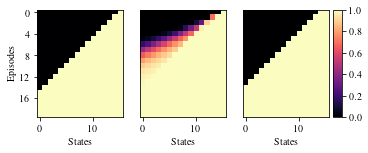

In [99]:
cur_prop_fig = script_plt_all_thetas(exp_dict)
#cur_prop_fig.tight_layout()

cur_prop_fig.savefig('/Users/anthony/Desktop/det-chain_value-prop.pdf', bbox_inches="tight")

mf 0.0
lvf_7 0.7
sf 1.0


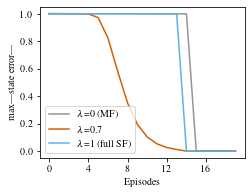

In [85]:
script_plt_all_errors(exp_dict)
plt.tight_layout()

plt.savefig('/Users/anthony/Desktop/det-chain_errors.pgf')